# 实验2 含一个隐藏层的平面数据分类

- **概述**：本次课程将训练包含1个隐藏层(由4个神经元组成)的神经网络（NN）模型,用于分类
    - 首先将读入数据，包括: 由二维点坐标组成的花的图案的X；对应的颜色标记Y
    - 然后使用sklearn中预设的linear_model.LogisticRegressionCV()进行分类，将效果作为基准
    - 最后使用自己设计的NN进行分类,达到良好的效果

- 本实验的**目标**包括：
    - 实现一个二分类神经网络，其具有一个隐藏层
    - 使用非线性激活函数，例如 tanh
    - 计算交叉熵损失
    - 实现前向和反向传播


## 1 - 包

- [numpy](https://www.numpy.org/) 
- [sklearn](http://scikit-learn.org/stable/)：Scikit-learn，是机器学习中常用的第三方模块，对常用的机器学习方法进行了封装，包括回归(Regression)、降维(Dimensionality Reduction)、分类(Classfication)、聚类(Clustering)等方法。
- [matplotlib](http://matplotlib.org) 

In [1]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt
import sklearn  
import sklearn.datasets
import sklearn.linear_model
from lib_testCases_v2 import *
from lib_public_tests import *
from lib_planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

%matplotlib inline

np.random.seed(2) # set a seed so that the results are consistent

%load_ext autoreload
%autoreload 2

## 2 - 数据集

### 2.1 加载数据集
让我们获取要使用的数据集。下面将调用本地模块中的函数 `load_planar_dataset()` 以加载一个名为"flower"的数据，其是具有2个类别的数据集，并赋值给`X`和`Y`

In [2]:
X, Y = load_planar_dataset()

#### 练习 1 - 数据集信息

- **目标**：
    - 确认训练样本的个数
    - X和Y的形状

In [3]:
# (≈ 3 lines of code)
# shape_X = ...
# shape_Y = ...
# training set size
# m = ...
# YOUR CODE STARTS HERE
shape_X = X.shape
shape_Y = Y.shape
m = (X.size)/shape_X[0]
# YOUR CODE ENDS HERE

print ('The shape of X is: ' + str(shape_X))
print ('The shape of Y is: ' + str(shape_Y))
print ('I have m = %d training examples!' % (m))

The shape of X is: (2, 400)
The shape of Y is: (1, 400)
I have m = 400 training examples!


**Expected Output**:
       
<table style="width:20%">
  <tr>
    <td> shape of X </td>
    <td> (2, 400) </td> 
  </tr>
  <tr>
    <td>shape of Y</td>
    <td>(1, 400) </td> 
    </tr>
    <tr>
    <td>m</td>
    <td> 400 </td> 
  </tr>
</table>

### 2.2 可视化数据集
- 使用matplotlib库中绘制散列点的函数scatter()来可视化数据集。

#### 2.2.1 scatter()简介
`matplotlib.pyplot.scatter()`[参考文档](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html)

在观察变量之间的关系时经常用到**散点图**。图中的点表示数据的关系。我们使用matplotlib库中的scatter()函数来画散点图。散点图同样被用于展示一个变量的改变会如何影响其他变量。

#### 2.2.2 scatter的语法
`matplotlib.pyplot.scatter(xaxis_data, yaxis_data, s = None, c = None, marker = None, cmap = None, vmin = None, vmax = None, alpha = None, linewidths = None, edgecolors = None)`[参考文档](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html)

* 参数描述（除X和Y之外，所有参数都是可选的，默认值为空）：
    * xaxis_data：X轴数据  
    * yaxis_data：Y轴数据  
    * s：点的尺寸  
    * c：点的颜色  
    * marker：点的式样  
    * cmap：颜色映射方式  
    * linewidths：点边缘的宽度  
    * edgecolor：点边缘的颜色  
    * Alpha：透明度，取值0到1之间，0表示完全透明，1表示不透明

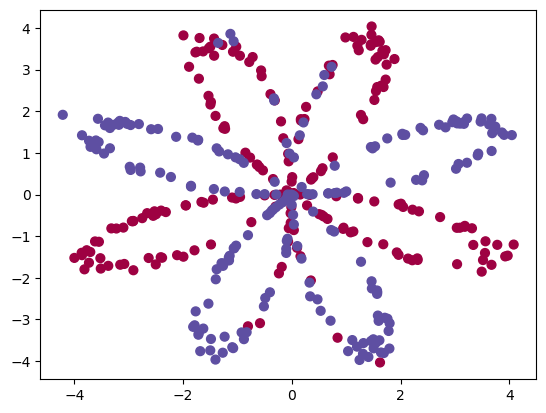

In [4]:
# Visualize the data:
plt.scatter(X[0, :], X[1, :], c=np.squeeze(Y), s=40, cmap=plt.cm.Spectral);

该数据看起来想一朵花，其中包含一些标记为红色（标记y=0）的点和一些标记为蓝色（y=1）的点。你的目标是构建一个模型来匹配该数据。即将矩形区域划分为红色区域和蓝色区域。

## 3 - 简单的逻辑回归
在构建完整的神经网络之前，让我们看看逻辑回归模型在本问题上的性能如何。下面将使用`sklearn`库的内置函数来训练一个逻辑回归分类器，并可视化预测结果。

Accuracy of logistic regression: 47.0%（正确分类的点数百分比）


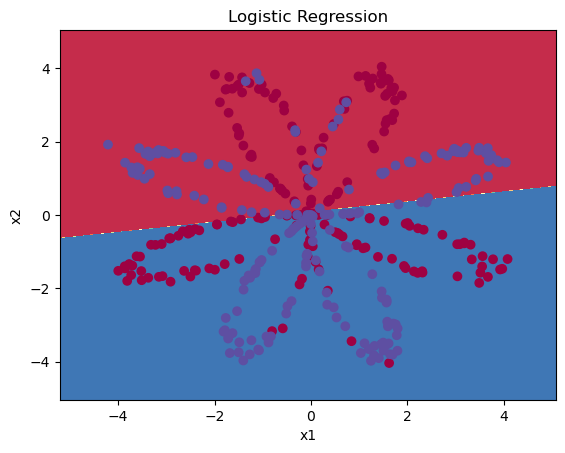

In [5]:
# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV();
clf.fit(X.T, Y.T.ravel());

# Plot the decision boundary for logistic regression
plot_decision_boundary(lambda x: clf.predict(x), X, np.squeeze(Y))
plt.title("Logistic Regression")

# Print accuracy
LR_predictions = clf.predict(X.T)
acc = (np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/Y.size*100.
print ('Accuracy of logistic regression: {}%（正确分类的点数百分比）'.format(np.squeeze(acc)))

**Expected Output**:

<table style="width:20%">
  <tr>
    <td>Accuracy</td>
    <td> 47% </td> 
  </tr>
  
</table>


**解释**：该数据库并非线性分离的，因此逻辑回归的性能不好，下面将尝试采用神经网络模型来分类。

## 4 - NN模型

### 4.0 模型结构及理论
<img src="images/classification_kiank.png" style="width:600px;height:300px;">

- 对于样本 $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1]}\tag{1}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2]}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5}$$

- 对于整个训练集, 代价函数 $J$ 定义如下: 
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$

### 4.1 - 定义NN结构

#### 练习 2 - layer_sizes 

- 定义三个变量
    - n_x: 输入层的尺寸
    - n_h: 隐藏层的尺寸 (设置为 4) 
    - n_y: 输出层的尺寸

In [6]:
"""
    # Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    # Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
"""
def layer_sizes(X, Y):    
    #(≈ 3 lines of code)
    # n_x = ... 
    # n_h = ...
    # n_y = ... 
    # YOUR CODE STARTS HERE
    n_x = X.shape[0] 
    n_h = 4
    n_y = Y.shape[0]
    # YOUR CODE ENDS HERE
    return (n_x, n_h, n_y)

In [7]:
t_X, t_Y = layer_sizes_test_case()
(n_x, n_h, n_y) = layer_sizes(t_X, t_Y)
print("The size of the input layer is: n_x = " + str(n_x))
print("The size of the hidden layer is: n_h = " + str(n_h))
print("The size of the output layer is: n_y = " + str(n_y))

layer_sizes_test(layer_sizes)

The size of the input layer is: n_x = 5
The size of the hidden layer is: n_h = 4
The size of the output layer is: n_y = 2
 All tests passed.


***Expected output***
```
The size of the input layer is: n_x = 5
The size of the hidden layer is: n_h = 4
The size of the output layer is: n_y = 2
```

### 4.2 - 初始化模型参数

<a name='ex-3'></a>
#### 练习 3 -  initialize_parameters

- **目标**：实现函数 `initialize_parameters()`.
    - 确保参数尺寸正确
    - 使用随机数初始化权重矩阵
    - 初始化偏置为全零向量
- 提示：
    - 使用 `np.random.randn(a,b) * 0.01` 随机初始化尺寸为 (a,b) 的矩阵
    - 使用 `np.zeros((a,b))` 来初始化尺寸为 (a,b) 的全零矩阵

In [9]:
"""
    # Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    # Returns:
    params -- python dictionary containing your parameters:
        W1 -- weight matrix of shape (n_h, n_x)
        b1 -- bias vector of shape (n_h, 1)
        W2 -- weight matrix of shape (n_y, n_h)
        b2 -- bias vector of shape (n_y, 1)
"""
def initialize_parameters(n_x, n_h, n_y):    
    np.random.seed(2) # we set up a seed so that your output matches ours although the initialization is random.    
    #(≈ 4 lines of code)
    # W1 = ...
    # b1 = ...
    # W2 = ...
    # b2 = ...
    # YOUR CODE STARTS HERE
    W1 = np.random.randn(n_h,n_x) * 0.01
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y,n_h) * 0.01
    b2 = np.zeros((n_y,1))
    # YOUR CODE ENDS HERE

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [10]:
n_x, n_h, n_y = initialize_parameters_test_case()
parameters = initialize_parameters(n_x, n_h, n_y)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

initialize_parameters_test(initialize_parameters)

W1 = [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.01057952 -0.00909008  0.00551454  0.02292208]]
b2 = [[0.]]
 All tests passed.


**Expected output**
```
W1 = [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.01057952 -0.00909008  0.00551454  0.02292208]]
b2 = [[0.]]
```

<a name='4-3'></a>
### 4.3 - 前向传播

<a name='ex-4'></a>
#### 练习4 - forward_propagation

使用下面的公式实现函数 `forward_propagation()`

$$Z^{[1]} =  W^{[1]} X + b^{[1]}\tag{1}$$ 
$$A^{[1]} = \tanh(Z^{[1]})\tag{2}$$
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}\tag{3}$$
$$\hat{Y} = A^{[2]} = \sigma(Z^{[2]})\tag{4}$$


**提示**:

- 确认上图中分类器的数学表达
- Sigmoid激活函数可调用本地模块中定义的 `sigmoid()`
- Tanh激活函数可调用 `np.tanh()`
- 具体步骤包括:
    1. 从"parameters" 中检索得到各个参数 (它是`initialize_parameters()`的返回值, 可以调用`parameters[".."]`来实现).
    2. 实现前向传播. 计算 $Z^{[1]}, A^{[1]}, Z^{[2]}$ and $A^{[2]}$.
- 将结果保存至 "cache" 中, 以供反向传播使用

In [13]:
"""
Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
"""
def forward_propagation(X, parameters):
    # Retrieve each parameter from the dictionary "parameters"
    #(≈ 4 lines of code)
    # W1 = ...
    # b1 = ...
    # W2 = ...
    # b2 = ...
    # YOUR CODE STARTS HERE
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    # YOUR CODE ENDS HERE
    
    # Implement Forward Propagation to calculate A2 (probabilities)
    # (≈ 4 lines of code)
    # Z1 = ...
    # A1 = ...
    # Z2 = ...
    # A2 = ...
    # YOUR CODE STARTS HERE
    Z1 = np.dot(W1,X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2,A1) + b2
    A2 = sigmoid(Z2)
    # YOUR CODE ENDS HERE
    
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [14]:
t_X, parameters = forward_propagation_test_case()
A2, cache = forward_propagation(t_X, parameters)
print("A2 = " + str(A2))

forward_propagation_test(forward_propagation)

A2 = [[0.21292656 0.21274673 0.21295976]]
 All tests passed.


***Expected output***
```
A2 = [[0.21292656 0.21274673 0.21295976]]
```

<a name='4-4'></a>
### 4.4 - 计算代价

上面已经计算得到了 $A^{[2]}$ (即 "`A2`"), 其包含对于所有样本的 $a^{[2](i)}$, 接下来可以根据下列公式计算代价函数:

$$J = - \frac{1}{m} \sum\limits_{i = 1}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small\tag{5}$$

<a name='ex-5'></a>
#### 练习 5 - compute_cost

实现函数 `compute_cost()` 用于计算代价值 $J$.

**提示**:
$$- \sum\limits_{i=1}^{m}  y^{(i)}\log(a^{[2](i)})\tag{6}$$:
- 有很多方法可以实现交叉熵. 例如, 下面的代码可以不使用循环来实现公式(6)的计算, 其是交叉熵的一部分:
```python
logprobs = np.multiply(np.log(A2),Y)
cost = - np.sum(logprobs)          
```
**注意**:
- 上述 `np.multiply()` 和 `np.sum()` 的方式可以简化为直接使用 `np.dot()`.
- `np.multiply`+`np.sum`的方式得到的数据类型为`float`, 而 `np.dot` 所得结果为一个二维的numpy数组.
- 可以使用 `np.squeeze()` 来去除多余的维度.
- 也可以使用`float()`来进行类型转换.

In [15]:
"""
Functions:
    Computes the cross-entropy cost given in equation (5)
Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
Returns:
    cost -- cross-entropy cost given equation (13)
"""
def compute_cost(A2, Y):
    m = Y.shape[1] # number of examples
    # Compute the cross-entropy cost
    # (≈ 2 lines of code)
    # logprobs = ...
    # cost = ...
    # YOUR CODE STARTS HERE
    logprobs = logprobs = np.multiply(Y ,np.log(A2)) + np.multiply((1-Y), np.log(1-A2))
    cost = (-1/m) * np.sum(logprobs)
    # YOUR CODE ENDS HERE
    
    cost = float(np.squeeze(cost))  # makes sure cost is the dimension we expect. 
                                    # E.g., turns [[17]] into 17 
    
    return cost

In [16]:
A2, t_Y = compute_cost_test_case()
cost = compute_cost(A2, t_Y)
print("cost = " + str(compute_cost(A2, t_Y)))

compute_cost_test(compute_cost)

cost = 0.6930587610394646
 All tests passed.


***Expected output***

`cost = 0.6930587610394646`


<a name='4-5'></a>
### 4.5 - 反向传播

<a name='ex-6'></a>
#### 练习 6 -  backward_propagation

实现函数 `backward_propagation()`.

**提示**:
反向传播通常来说是深度学习中最难的部分(因为有很多数学原理和公式). 下面的图片来自PPT. 你可以使用右侧的六个等式来实现向量化版本的实现.

<img src="images/grad_summary.png" width=1000>
<caption><center><font color='purple'><b>Figure 1</b>: Backpropagation. Use the six equations on the right.</font></center></caption>
- Tips:
    - 为了计算 dZ1 你需要计算 $g^{[1]'}(Z^{[1]})$. 因为 $g^{[1]}(.)$ 是 tanh 激活函数, 如果 $a = g^{[1]}(z)$, 则 $g^{[1]'}(z) = 1-a^2$. 因此实现公式$g^{[1]'}(Z^{[1]})$的代码是: `(1 - np.power(A1, 2))`.

In [18]:
"""
Function:
    Implement the backward propagation using the instructions above.
Arguments:
    parameters -- python dictionary containing our parameters
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
"""
def backward_propagation(parameters, cache, X, Y):
    m = X.shape[1]
    # First, retrieve W1 and W2 from the dictionary "parameters".
    #(≈ 2 lines of code)
    # W1 = ...
    # W2 = ...
    # YOUR CODE STARTS HERE
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    # YOUR CODE ENDS HERE
        
    # Retrieve also A1 and A2 from dictionary "cache".
    #(≈ 2 lines of code)
    # A1 = ...
    # A2 = ...
    # YOUR CODE STARTS HERE
    A1 = cache["A1"]
    A2 = cache["A2"]
    # YOUR CODE ENDS HERE
    
    # Backward propagation: calculate dW1, db1, dW2, db2. 
    #(≈ 6 lines of code, corresponding to 6 equations on slide above)
    # dZ2 = ...
    # dW2 = ...
    # db2 = ...
    # dZ1 = ...
    # dW1 = ...
    # db1 = ...
    # YOUR CODE STARTS HERE
    dZ2 = A2 - Y
    dW2 = (1/m) * np.dot(dZ2,A1.T)
    db2 = (1/m) *(np.sum(dZ2,axis=1,keepdims=True))
    dZ1 = np.dot(W2.T,dZ2) * (1 - np.power(A1,2))
    dW1 = (1/m) *(np.dot(dZ1,X.T))
    db1 = (1/m) *(np.sum(dZ1, axis=1, keepdims=True))
    # YOUR CODE ENDS HERE
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

In [19]:
parameters, cache, t_X, t_Y = backward_propagation_test_case()

grads = backward_propagation(parameters, cache, t_X, t_Y)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

backward_propagation_test(backward_propagation)

dW1 = [[ 0.00301023 -0.00747267]
 [ 0.00257968 -0.00641288]
 [-0.00156892  0.003893  ]
 [-0.00652037  0.01618243]]
db1 = [[ 0.00176201]
 [ 0.00150995]
 [-0.00091736]
 [-0.00381422]]
dW2 = [[ 0.00078841  0.01765429 -0.00084166 -0.01022527]]
db2 = [[-0.16655712]]
 All tests passed.


***Expected output***
```
dW1 = [[ 0.00301023 -0.00747267]
 [ 0.00257968 -0.00641288]
 [-0.00156892  0.003893  ]
 [-0.00652037  0.01618243]]
db1 = [[ 0.00176201]
 [ 0.00150995]
 [-0.00091736]
 [-0.00381422]]
dW2 = [[ 0.00078841  0.01765429 -0.00084166 -0.01022527]]
db2 = [[-0.16655712]]
```

<a name='4-6'></a>
### 4.6 - 参数更新

<a name='ex-7'></a>
#### 练习 7 - update_parameters

使用梯度下降法进行参数更新. 为了更新(W1, b1, W2, b2), 需要用到 (dW1, db1, dW2, db2).

**梯度更新基本法则**: $\theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$, 其中 $\alpha$ 是学习率, $\theta$ 表示某参数.

<img src="images/sgd.gif" style="width:400;height:400;"> <img src="images/sgd_bad.gif" style="width:400;height:400;">
<caption><center><font color='purple'><b>Figure 2</b>: The gradient descent algorithm with a good learning rate (converging) and a bad learning rate (diverging). Images courtesy of Adam Harley.</font></center></caption>

<img src="images/sgd.gif" style="width:400;height:400;"> <img src="images/sgd_bad.gif" style="width:400;height:400;">
<caption><center><font color='purple'><b>Figure 2</b>: The gradient descent algorithm with a good learning rate (converging) and a bad learning rate (diverging). Images courtesy of Adam Harley.</font></center></caption>






In [20]:
"""
Function:
    Updates parameters using the gradient descent update rule given above
Arguments:
    parameters -- python dictionary containing your parameters
    grads -- python dictionary containing your gradients
Returns:
    parameters -- python dictionary containing your updated parameters
"""
def update_parameters(parameters, grads, learning_rate = 1.2):
    # Retrieve each parameter from the dictionary "parameters"
    #(≈ 4 lines of code)
    # W1 = ...
    # b1 = ...
    # W2 = ...
    # b2 = ...
    # YOUR CODE STARTS HERE
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    # YOUR CODE ENDS HERE
    
    # Retrieve each gradient from the dictionary "grads"
    #(≈ 4 lines of code)
    # dW1 = ...
    # db1 = ...
    # dW2 = ...
    # db2 = ...
    # YOUR CODE STARTS HERE
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    # YOUR CODE ENDS HERE
    
    # Update rule for each parameter
    #(≈ 4 lines of code)
    # W1 = ...
    # b1 = ...
    # W2 = ...
    # b2 = ...
    # YOUR CODE STARTS HERE
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    # YOUR CODE ENDS HERE
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [34]:
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

update_parameters_test(update_parameters)

W1 = [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]
b1 = [[-1.02420756e-06]
 [ 1.27373948e-05]
 [ 8.32996807e-07]
 [-3.20136836e-06]]
W2 = [[-0.01041081 -0.04463285  0.01758031  0.04747113]]
b2 = [[0.00010457]]
 All tests passed.


***Expected output***
```
W1 = [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]
b1 = [[-1.02420756e-06]
 [ 1.27373948e-05]
 [ 8.32996807e-07]
 [-3.20136836e-06]]
W2 = [[-0.01041081 -0.04463285  0.01758031  0.04747113]]
b2 = [[0.00010457]]
```

<a name='4-7'></a>
### 4.7 - 整合

将你的函数整合至 `nn_model()`

<a name='ex-8'></a>
#### 练习 8 - nn_model

在 `nn_model()` 中构建你的神经网络.

In [27]:
"""
Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
"""
def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    # Initialize parameters
    #(≈ 1 line of code)
    # parameters = ...
    # YOUR CODE STARTS HERE
    parameters = initialize_parameters(n_x, n_h, n_y)
    # YOUR CODE ENDS HERE
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):
        #(≈ 4 lines of code)
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        # A2, cache = ...
        # Cost function. Inputs: "A2, Y". Outputs: "cost".
        # cost = ...
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        # grads = ...
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        # parameters = ...
        # YOUR CODE STARTS HERE
        A2, cache = forward_propagation(X, parameters)
        cost = compute_cost(A2, Y)
        grads = backward_propagation(parameters, cache, X, Y)
        parameters = update_parameters(parameters, grads)
        # YOUR CODE ENDS HERE
        
        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

In [28]:
t_X, t_Y = nn_model_test_case()
parameters = nn_model(t_X, t_Y, 4, num_iterations=10000, print_cost=True)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

nn_model_test(nn_model)

Cost after iteration 0: 0.692739
Cost after iteration 1000: 0.000218
Cost after iteration 2000: 0.000107
Cost after iteration 3000: 0.000071
Cost after iteration 4000: 0.000053
Cost after iteration 5000: 0.000042
Cost after iteration 6000: 0.000035
Cost after iteration 7000: 0.000030
Cost after iteration 8000: 0.000026
Cost after iteration 9000: 0.000023
W1 = [[-0.65848169  1.21866811]
 [-0.76204273  1.39377573]
 [ 0.5792005  -1.10397703]
 [ 0.76773391 -1.41477129]]
b1 = [[ 0.287592  ]
 [ 0.3511264 ]
 [-0.2431246 ]
 [-0.35772805]]
W2 = [[-2.45566237 -3.27042274  2.00784958  3.36773273]]
b2 = [[0.20459656]]
 All tests passed.


***Expected output***
```
Cost after iteration 0: 0.692739
Cost after iteration 1000: 0.000218
Cost after iteration 2000: 0.000107
...
Cost after iteration 8000: 0.000026
Cost after iteration 9000: 0.000023
W1 = [[-0.65848169  1.21866811]
 [-0.76204273  1.39377573]
 [ 0.5792005  -1.10397703]
 [ 0.76773391 -1.41477129]]
b1 = [[ 0.287592  ]
 [ 0.3511264 ]
 [-0.2431246 ]
 [-0.35772805]]
W2 = [[-2.45566237 -3.27042274  2.00784958  3.36773273]]
b2 = [[0.20459656]]
```

<a name='5'></a>
## 5 - 测试模型

<a name='5-1'></a>
### 5.1 - 预测

<a name='ex-9'></a>
#### 练习 9 - predict

通过函数 `predict()` 实现预测.
使用前向传播来预测结果.

**提醒**: $y_{prediction} = \mathbb 1 \text{{activation > 0.5}} = \begin{cases}
      1 & \text{if}\ activation > 0.5 \\
      0 & \text{otherwise}
    \end{cases}$  
    
例如, 如果你想基于一个阈值将矩阵X的元素设置为0或1, 可以这样做: ```X_new = (X > threshold)```

In [29]:
"""
Function:
    Using the learned parameters, predicts a class for each example in X
Arguments:
    parameters -- python dictionary containing your parameters
    X -- input data of size (n_x, m)
Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
"""
def predict(parameters, X):
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    #(≈ 2 lines of code)
    # A2, cache = ...
    # predictions = ...
    # YOUR CODE STARTS HERE
    A2, cache = forward_propagation(X, parameters)
    predictions = (A2 > 0.5)
    # YOUR CODE ENDS HERE
    
    return predictions

In [30]:
parameters, t_X = predict_test_case()

predictions = predict(parameters, t_X)
print("Predictions: " + str(predictions))

predict_test(predict)

Predictions: [[ True False  True]]
 All tests passed.


***Expected output***
```
Predictions: [[ True False  True]]
```

<a name='5-2'></a>
### 5.2 - 在 Planar 测试数据中进行测试

Cost after iteration 0: 0.693048
Cost after iteration 1000: 0.288083
Cost after iteration 2000: 0.254385
Cost after iteration 3000: 0.233864
Cost after iteration 4000: 0.226792
Cost after iteration 5000: 0.222644
Cost after iteration 6000: 0.219731
Cost after iteration 7000: 0.217504
Cost after iteration 8000: 0.219465
Cost after iteration 9000: 0.218610


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

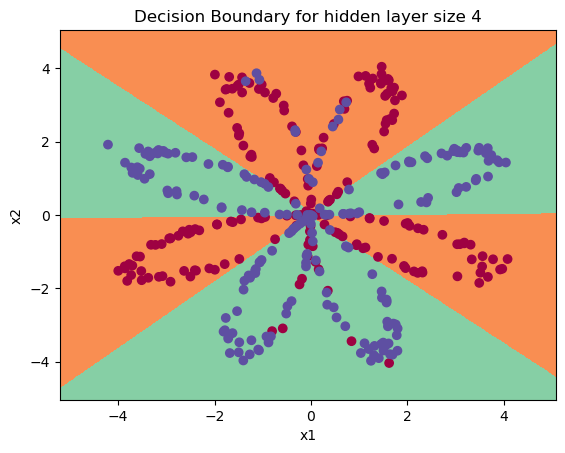

In [31]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

In [32]:
# Print accuracy
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100) + '%')

Accuracy: 90%


**Expected Output**: 

<table style="width:30%">
  <tr>
    <td><b>Accuracy</b></td>
    <td> 90% </td> 
  </tr>
</table>

相对逻辑回归来说, 该准确率可以说相当高了. 模型已经学会了花瓣的模式.
与逻辑回归不同, 神经网络能够学习到高度非线性的决策边界.

<a name='6'></a>
## 6 - 调整隐藏层尺寸 (可选)

运行下面的代码(约花费1~2分钟). 观察具有不同的隐藏层尺寸模型的性能.

Accuracy for 1 hidden units: 67.5 %
Accuracy for 2 hidden units: 67.25 %
Accuracy for 3 hidden units: 90.75 %
Accuracy for 4 hidden units: 90.5 %
Accuracy for 5 hidden units: 91.25 %
Accuracy for 20 hidden units: 90.5 %
Accuracy for 50 hidden units: 90.75 %


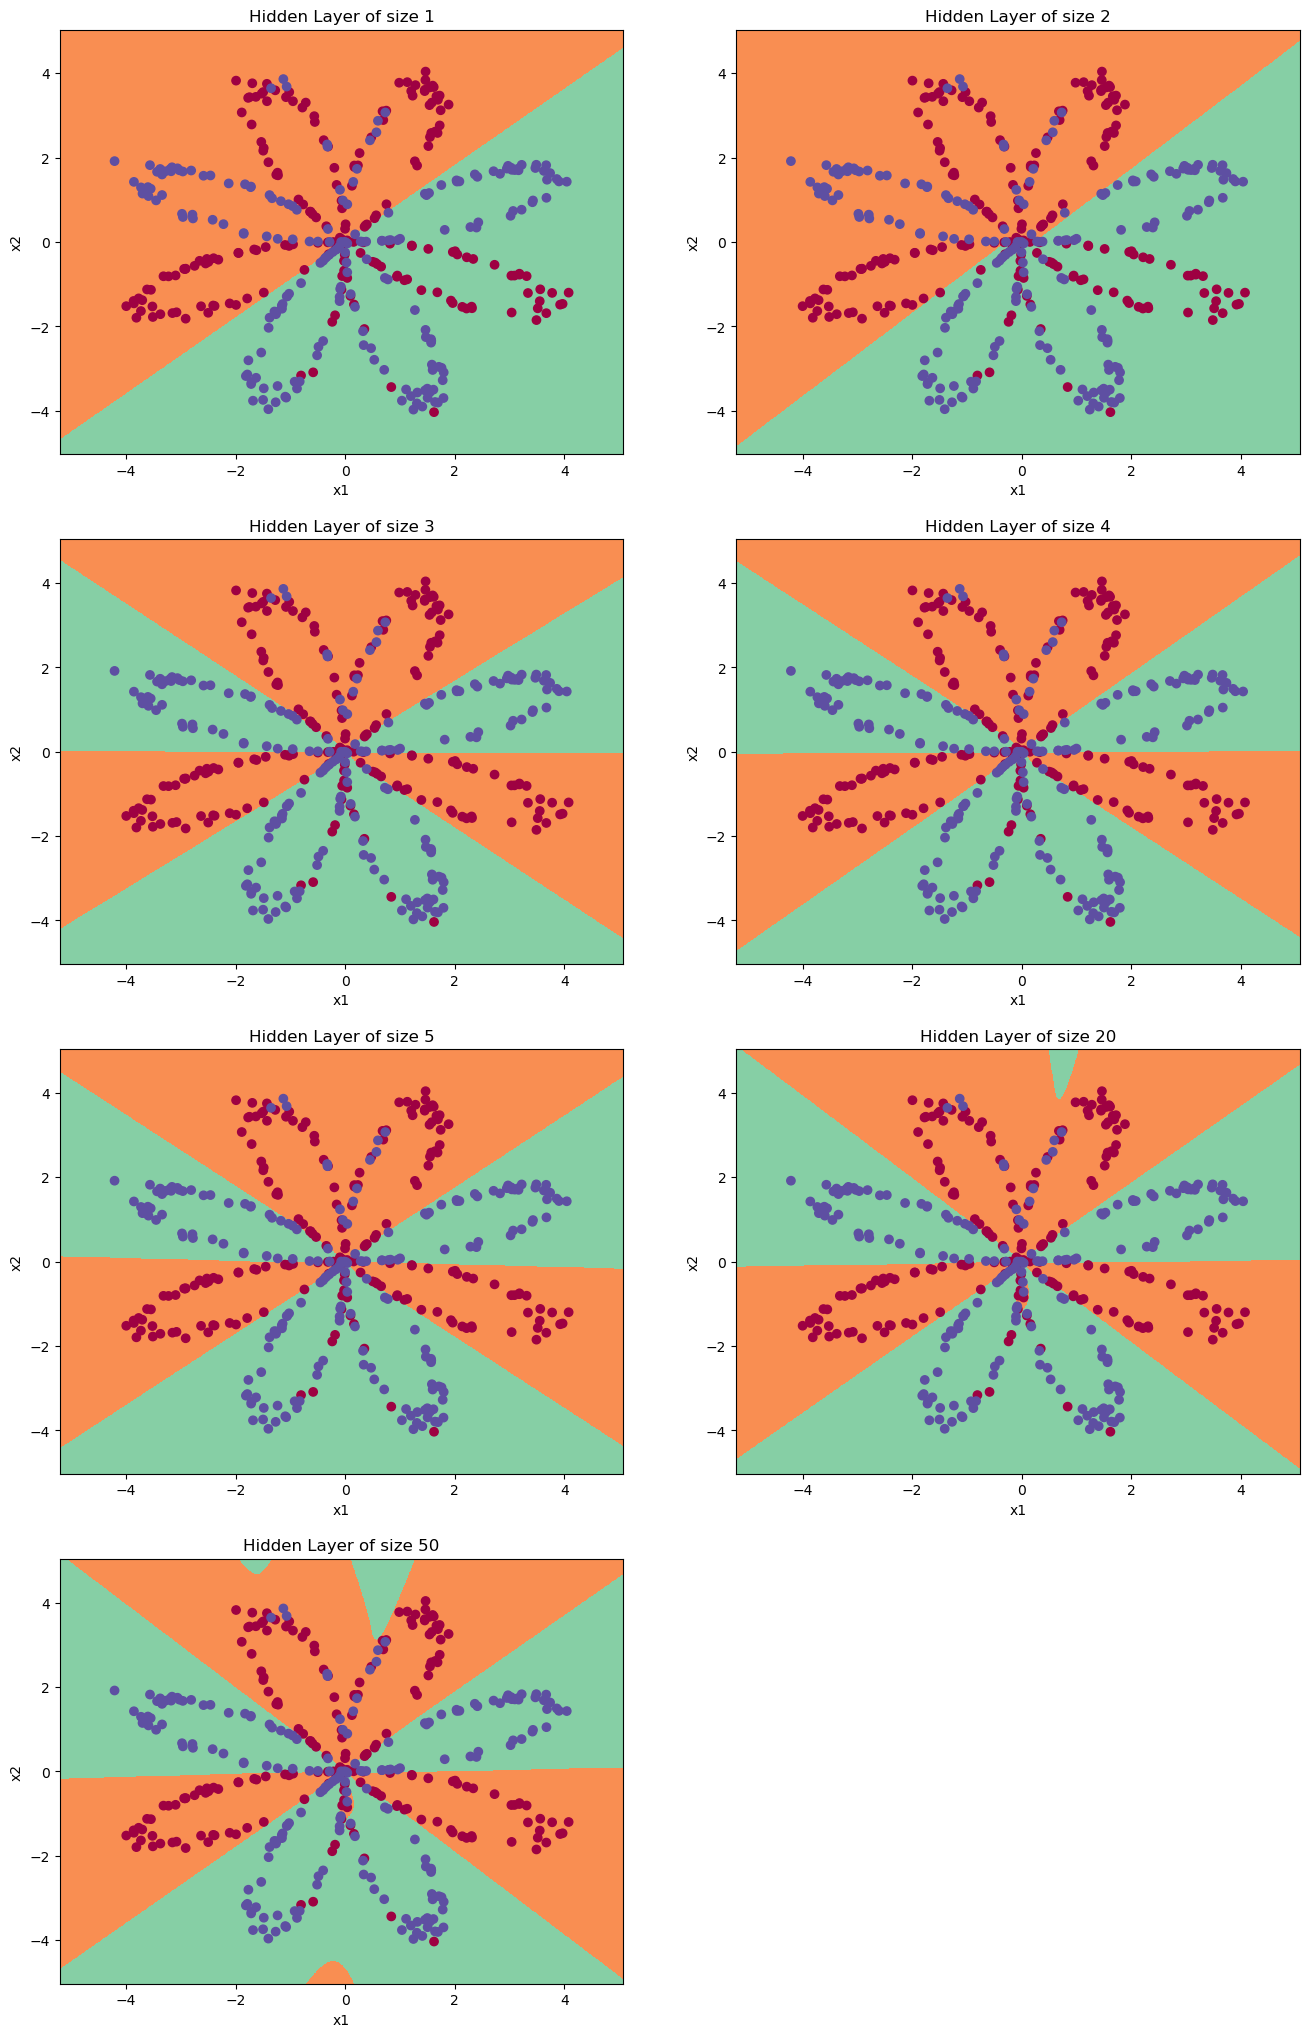

In [33]:
# This may take about 2 minutes to run

plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

**解读**:
- 较大的模型(具有更多隐藏层单元)能够更好地拟合训练集，直到最大的模型对数据产生过拟合.
- 最好的隐藏层大小似乎是在 n_h = 5 左右, 此时没有明显的过拟合现象出现.
- 稍后, 你将熟悉正则化, 它允许您使用非常大的模型(例如n_h = 50)而不会过度拟合.

**其他探索问题**:
- 如果将 tanh 激活函数改成 sigmoid 或 ReLU 会如何?
- 更改学习率会如何?
- 更改数据集会如何?

**References**:

- http://scs.ryerson.ca/~aharley/neural-networks/
- http://cs231n.github.io/neural-networks-case-study/